# Benchmarking Risk Model Simulations

## Generate Quantum Risk Models
We create two sets of quantum risk model circuits---one with lower risk item counts (2 - 6) the other with higher counts (7-13). The quantum risk models are used for benchmarking different quantum simulators---Qiskit `AerSimulator`, geqo `simulatorStatevectorNumpy`, and geqo `statevectorSimulatorCuPy`.

In [5]:
import numpy as np
from itertools import combinations
from geqo.algorithms import RiskModel


def generate_prob_model(n, num_edges=None, node_prefix="N"):
    np.random.seed(10)
    if n < 1:
        raise ValueError("Number of nodes must be at least 1")

    # Generate node labels (e.g., N0, N1, ..., or A, B, ...)
    if node_prefix.isalpha() and len(node_prefix) == 1:
        # Use letters if n <= 26 and prefix is a letter
        if n <= 26:
            nodes = [chr(ord(node_prefix) + i) for i in range(n)]
        else:
            nodes = [f"{node_prefix}{i}" for i in range(n)]
    else:
        nodes = [f"{node_prefix}{i}" for i in range(n)]

    # Generate random intrinsic probabilities for each node
    probsNodes = {node: np.random.uniform(0, 1) for node in nodes}

    # Default number of edges: floor(n/2), or user-specified
    if num_edges is None:
        num_edges = n - 1  # Integer division for floor(n/2)
    num_edges = min(
        num_edges, n * (n - 1)
    )  # Max possible directed edges without self-loops

    if num_edges < 0:
        raise ValueError("Number of edges cannot be negative")

    # Generate random edges
    possible_edges = list(
        combinations(nodes, 2)
    )  # All possible directed pairs (A,B), (A,C), ...
    np.random.shuffle(possible_edges)  # Randomize edge order
    selected_edges = possible_edges[:num_edges]

    # Generate random transition probabilities for selected edges
    probsEdges = {(src, tgt): np.random.uniform(0, 1) for src, tgt in selected_edges}

    return probsNodes, probsEdges


# Create risk models with # of items from 2 to 5
instances = []
for n in range(2, 6):
    probsNodes, probsEdges = generate_prob_model(n, num_edges=None, node_prefix="N")
    instances.append((probsNodes, probsEdges))
seq_cv = []
for node_probs, edge_probs in instances:
    seq, cv = RiskModel(node_probs=node_probs, edge_probs=edge_probs)
    seq_cv.append((seq, cv))

# Create risk models with # of items from 6 to 13
instances = []
instances2 = []
for n in range(6, 14):
    probsNodes, probsEdges = generate_prob_model(n, num_edges=None, node_prefix="N")
    instances2.append((probsNodes, probsEdges))
seq_cv2 = []
for node_probs, edge_probs in instances2:
    seq, cv = RiskModel(node_probs=node_probs, edge_probs=edge_probs)
    seq_cv2.append((seq, cv))

## Construct Grover operators based on the quantum risk models

In [6]:
from geqo.operations import QuantumControl
from geqo.gates import PauliX, PauliZ
from geqo.core import Sequence
from geqo.utils import embedSequences


def grover_op(seq):
    n = len(seq.qubits)
    seqList = [
        (
            QuantumControl([1] * (n - 1), PauliZ()),
            [f"{i}" for i in range(n)],
            [],
        ),  # mark 11111 state
        (seq.getInverse(), [f"{i}" for i in range(n)], []),  # inverse operator
        (PauliX(), ["0"], []),  # the global -1
        (PauliZ(), ["0"], []),
        (PauliX(), ["0"], []),
        (PauliZ(), ["0"], []),
        (PauliX(), ["0"], []),  # Phase -1 on 0000 only, 1 else
        (
            QuantumControl([0] * (n - 1), PauliZ()),
            [f"{i}" for i in range(1, n)] + ["0"],
            [],
        ),
        (PauliX(), ["0"], []),
        (seq, [f"{i}" for i in range(n)], []),  # the operator
    ]

    grov = Sequence(
        seq.qubits, seq.bits, seqList
    )  # Create the Grover operator as Sequence
    return embedSequences(grov)


grovs = [grover_op(seq) for seq, _ in seq_cv]
grovs2 = [grover_op(seq) for seq, _ in seq_cv2]

## Create different powers of Grover operators
We need to raise the Grover operators to different powers in the QAE circuit.

In [7]:
# raise Grover operators to different powers and store them in lists
pows = []
for n in range(2, 6):
    pow1 = Sequence(
        [f"{i}" for i in range(n)], [], [(grovs[n - 2], [f"{i}" for i in range(n)], [])]
    )
    pows_n = [embedSequences(pow1)]
    for _ in range(6):
        pow = Sequence(
            [f"{i}" for i in range(n)],
            [],
            [
                (pows_n[-1], [f"{i}" for i in range(n)], []),
                (pows_n[-1], [f"{i}" for i in range(n)], []),
            ],
        )
        pows_n.append(embedSequences(pow))
    pows.append(pows_n)
pows2 = []
for n in range(6, 14):
    pow1 = Sequence(
        [f"{i}" for i in range(n)],
        [],
        [(grovs2[n - 6], [f"{i}" for i in range(n)], [])],
    )
    pows_n = [embedSequences(pow1)]
    for _ in range(6):
        pow = Sequence(
            [f"{i}" for i in range(n)],
            [],
            [
                (pows_n[-1], [f"{i}" for i in range(n)], []),
                (pows_n[-1], [f"{i}" for i in range(n)], []),
            ],
        )
        pows_n.append(embedSequences(pow))
    pows2.append(pows_n)

## Build QAE circuits

In [9]:
from geqo.gates import Hadamard
from geqo.operations import Measure
from geqo.algorithms import InverseQFT

# Build QAE circuits
qaes = []
for n in range(2, 6):
    qft = InverseQFT(7)
    seq = seq_cv[n - 2][0]
    pow = pows[n - 2]
    gatesAndTargets = []
    for i in range(7):
        gatesAndTargets.append((Hadamard(), [f"p{i}"], []))

    gatesAndTargets.append((seq, [f"{i}" for i in range(n)], []))
    for j in reversed(range(7)):
        for gnt in pow[j].gatesAndTargets:
            if isinstance(gnt[0], QuantumControl):
                gate = QuantumControl([1] + gnt[0].onoff, gnt[0].qop)
                gatesAndTargets.append((gate, [f"p{6 - j}"] + gnt[1], []))
            else:
                gate = QuantumControl([1], gnt[0])
                gatesAndTargets.append((gate, [f"p{6 - j}"] + gnt[1], []))
    gatesAndTargets.append((qft, ["p0", "p1", "p2", "p3", "p4", "p5", "p6"], []))
    gatesAndTargets.append(
        (Measure(7), [f"p{i}" for i in range(7)], [0, 1, 2, 3, 4, 5, 6])
    )
    seq2 = Sequence(
        ["p0", "p1", "p2", "p3", "p4", "p5", "p6"] + [f"{i}" for i in range(n)],
        [*range(7)],
        gatesAndTargets,
    )
    qaes.append(embedSequences(seq2))

qaes2 = []
for n in range(6, 14):
    qft = InverseQFT(7)
    seq = seq_cv2[n - 6][0]
    pow = pows2[n - 6]
    gatesAndTargets = []
    for i in range(7):
        gatesAndTargets.append((Hadamard(), [f"p{i}"], []))

    gatesAndTargets.append((seq, [f"{i}" for i in range(n)], []))
    for j in reversed(range(7)):
        for gnt in pow[j].gatesAndTargets:
            if isinstance(gnt[0], QuantumControl):
                gate = QuantumControl([1] + gnt[0].onoff, gnt[0].qop)
                gatesAndTargets.append((gate, [f"p{6 - j}"] + gnt[1], []))
            else:
                gate = QuantumControl([1], gnt[0])
                gatesAndTargets.append((gate, [f"p{6 - j}"] + gnt[1], []))
    gatesAndTargets.append((qft, ["p0", "p1", "p2", "p3", "p4", "p5", "p6"], []))
    gatesAndTargets.append(
        (Measure(7), [f"p{i}" for i in range(7)], [0, 1, 2, 3, 4, 5, 6])
    )
    seq2 = Sequence(
        ["p0", "p1", "p2", "p3", "p4", "p5", "p6"] + [f"{i}" for i in range(n)],
        [*range(7)],
        gatesAndTargets,
    )
    qaes2.append(embedSequences(seq2))

## Benchmark Risk Models with Cupy*/Numpy statevector simulators and Qiskit AerSimulator
*The Cupy benchmark is executed with the T4 GPU on Google Colab.

In [ ]:
from geqo.simulators import statevectorSimulatorCuPy, simulatorStatevectorNumpy
from geqo.utils import cupyWarmup
from qiskit import transpile
from qiskit.qasm3 import loads
from qiskit_aer import AerSimulator
import cupy as cp
import time
import psutil
import os

process = psutil.Process(os.getpid())
cupyWarmup()  # warm up the CUDA driver

qiskit_time = []
numpy_time = []
cupy_time = []
for n in range(2, 6):
    cv = seq_cv[n - 2][1]
    seq = qaes[n - 2]

    # AerSimulator
    s = simulatorStatevectorNumpy(7 + n, 7)
    for c in cv:
        s.setValue(c, cv[c])
    s.prepareBackend([qft])

    code = s.sequence_to_qasm3(seq)
    qc = loads(code)
    qc.save_probabilities(qubits=[*range(7)])
    sim_aer = AerSimulator()

    mem_before = process.memory_info().rss
    qiskit_start = time.time()
    qc_t = transpile(qc, sim_aer)
    result = sim_aer.run(qc_t).result()
    qiskit_end = time.time()
    mem_after = process.memory_info().rss
    mem_used = (mem_after - mem_before) / 1e6  # MB
    print(
        f"{n} risk items --- AerSimulator runtime: {qiskit_end - qiskit_start:.4f}s, "
        f"AerSimulator RAM used: {mem_used:.2f} MB"
    )
    qiskit_time.append(qiskit_end - qiskit_start)

    # Numpy simulator
    sim_np = simulatorStatevectorNumpy(7 + n, 7)
    for c in cv:
        sim_np.setValue(c, cv[c])
    sim_np.prepareBackend([qft])

    mem_before = process.memory_info().rss
    numpy_start = time.time()
    sim_np.apply(seq, [*range(7 + n)], [*range(7)])
    numpy_end = time.time()
    mem_after = process.memory_info().rss
    mem_used = (mem_after - mem_before) / 1e6

    print(
        f"{n} risk items --- NumPy runtime: {numpy_end - numpy_start:.4f}s, "
        f"Numpy RAM used: {mem_used:.2f} MB"
    )
    numpy_time.append(numpy_end - numpy_start)

    # Cupy simulator
    sim_cp = statevectorSimulatorCuPy(7 + n, 7)
    for c in cv:
        sim_cp.setValue(c, cv[c])
    sim_cp.prepareBackend([qft])

    cp._default_memory_pool.free_all_blocks()

    cupy_start = time.time()
    sim_cp.apply(seq, [*range(7 + n)], [*range(7)])
    cupy_end = time.time()

    mem_allocated = cp.get_default_memory_pool().used_bytes()
    mem_total = cp.cuda.Device(0).mem_info[1]  # total GPU memory
    mem_used_percent = mem_allocated / mem_total * 100

    print(
        f"{n} risk items --- cupy runtime: {cupy_end - cupy_start:.4f}s, "
        f"Cupy GPU memory used: {mem_allocated / 1e6:.2f} MB ({mem_used_percent:.1f}%)"
    )
    cupy_time.append(cupy_end - cupy_start)

2 risk items --- AerSimulator runtime: 12.9060s, AerSimulator RAM used: 23.21 MB
2 risk items --- NumPy runtime: 9.9349s, Numpy RAM used: 0.13 MB
2 risk items --- cupy runtime: 7.6551s, Cupy GPU memory used: 0.01 MB (0.0%)
3 risk items --- AerSimulator runtime: 178.1314s, AerSimulator RAM used: 114.24 MB
3 risk items --- NumPy runtime: 27.2260s, Numpy RAM used: 0.00 MB
3 risk items --- cupy runtime: 4.4133s, Cupy GPU memory used: 0.02 MB (0.0%)
4 risk items --- AerSimulator runtime: 374.9958s, AerSimulator RAM used: 41.94 MB
4 risk items --- NumPy runtime: 65.6965s, Numpy RAM used: 0.00 MB
4 risk items --- cupy runtime: 4.8452s, Cupy GPU memory used: 0.04 MB (0.0%)
5 risk items --- AerSimulator runtime: 811.7222s, AerSimulator RAM used: 4.20 MB
5 risk items --- NumPy runtime: 184.5879s, Numpy RAM used: 0.13 MB
5 risk items --- cupy runtime: 4.2080s, Cupy GPU memory used: 0.07 MB (0.0%)


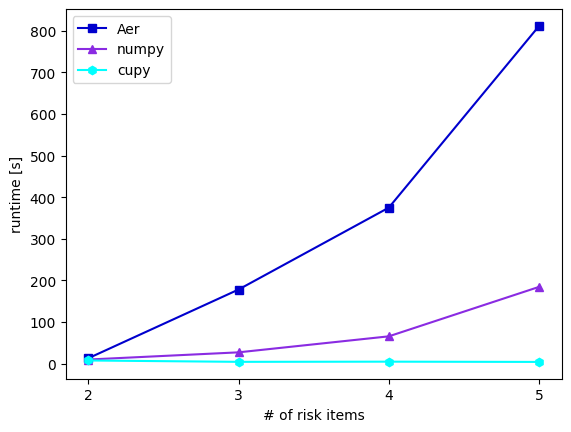

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(2, 6), qiskit_time, label="Aer", marker="s", color="mediumblue")
plt.plot(range(2, 6), numpy_time, label="numpy", marker="^", color="blueviolet")
plt.plot(range(2, 6), cupy_time, label="cupy", marker="h", color="cyan")
plt.xlabel("# of risk items")
plt.xticks([2, 3, 4, 5])
plt.ylabel("runtime [s]")
plt.legend()

In [ ]:
cupy_time2 = []
for n in range(6, 14):
    cv = seq_cv2[n - 6][1]
    seq2 = qaes2[n - 6]

    sim2 = statevectorSimulatorCuPy(7 + n, 7)
    for c in cv:
        sim2.setValue(c, cv[c])
    sim2.prepareBackend([qft])

    cp._default_memory_pool.free_all_blocks()

    cupy_start = time.time()
    sim2.apply(seq2, [*range(7 + n)], [*range(7)])
    cupy_end = time.time()

    mem_allocated = cp.get_default_memory_pool().used_bytes()
    mem_total = cp.cuda.Device(0).mem_info[1]
    mem_used_percent = mem_allocated / mem_total * 100

    print(f"{n} risk items --- cupy runtime: {cupy_end - cupy_start}s")
    print(f"GPU memory used: {mem_allocated / 1e6:.2f} MB ({mem_used_percent:.1f}%)")
    cupy_time2.append(cupy_end - cupy_start)

6 risk items --- cupy runtime: 5.414300203323364s
GPU memory used: 0.21 MB (0.0%)
7 risk items --- cupy runtime: 7.646087408065796s
GPU memory used: 0.35 MB (0.0%)
8 risk items --- cupy runtime: 7.833507061004639s
GPU memory used: 0.61 MB (0.0%)
9 risk items --- cupy runtime: 11.382660865783691s
GPU memory used: 1.14 MB (0.0%)
10 risk items --- cupy runtime: 8.12359619140625s
GPU memory used: 2.18 MB (0.0%)
11 risk items --- cupy runtime: 18.57967519760132s
GPU memory used: 4.28 MB (0.0%)
12 risk items --- cupy runtime: 60.897520542144775s
GPU memory used: 8.48 MB (0.1%)
13 risk items --- cupy runtime: 190.85037183761597s
GPU memory used: 16.87 MB (0.1%)


Text(0.5, 1.0, 'CuPy statevector simulator scalability')

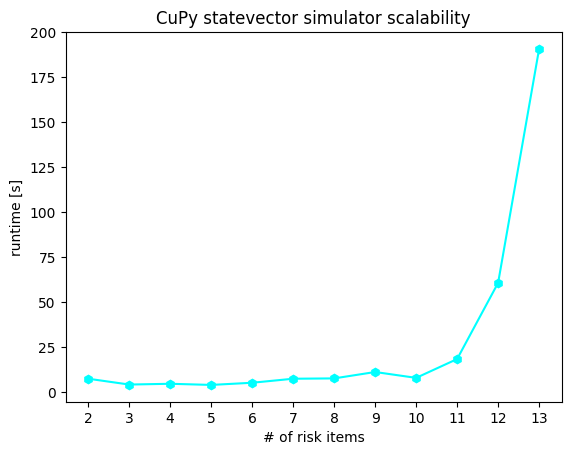

In [14]:
fig, ax = plt.subplots()
ax.plot(range(2, 14), cupy_time + cupy_time2, marker="h", color="cyan")
ax.set_xlabel("# of risk items")
ax.set_xticks([*range(2, 14)])
ax.set_ylabel("runtime [s]")
ax.set_title("CuPy statevector simulator scalability")